# Overview: Fitting Individual Sources

This notebook provides an example of how to use the models in `brutus` to model individual sources using both the `SEDmaker` class and the `BruteForce` class.

# Preamble

As always, let's just set up a nice environment to run these tests.

In [1]:
from __future__ import print_function, division
from six.moves import range
import sys
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
import h5py

In [2]:
# plot in-line within the notebook
%matplotlib inline

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

In [3]:
import brutus

# Models

For this example, we will use the MIST v1.2 models with the empirical corrections described from the release paper evaluated over the Pan-STARRS and 2MASS filters.

In [5]:
from brutus import filters
from brutus import seds
from brutus import utils as butils

filt = filters.ps[:-2] + filters.tmass

# import EEP tracks
nnfile = '../data/DATAFILES/nn_c3k.h5'
mistfile = '../data/DATAFILES/MIST_1.2_EEPtrk.h5'
sedmaker = seds.SEDmaker(filters=filt, nnfile=nnfile, mistfile=mistfile)

# import MIST model grid
gridfile = '../data/DATAFILES/grid_mist_v9.h5'
(models_mist, labels_mist, lmask_mist) = butils.load_models(gridfile, filters=filt)

Filters: ['PS_g', 'PS_r', 'PS_i', 'PS_z', 'PS_y', '2MASS_J', '2MASS_H', '2MASS_Ks']
Constructing MIST library...done!
Computing age weights for track (mini, feh, afe) = (300.0, 0.5, 0.0)            
Initializing FastNN predictor...done!
Reading filter 2MASS_Ks           


# Sampling

The `SEDmaker` class allows us to generate models and stellar parameters using various function calls. This means we can easily insert it into a framework to estimate posteriors that require generating models "on the fly", such as **Markov Chain Monte Carlo** or **Nested Sampling**. 

To avoid getting into the weeds, in this demo we will just illustrate what the likelihood looks like.

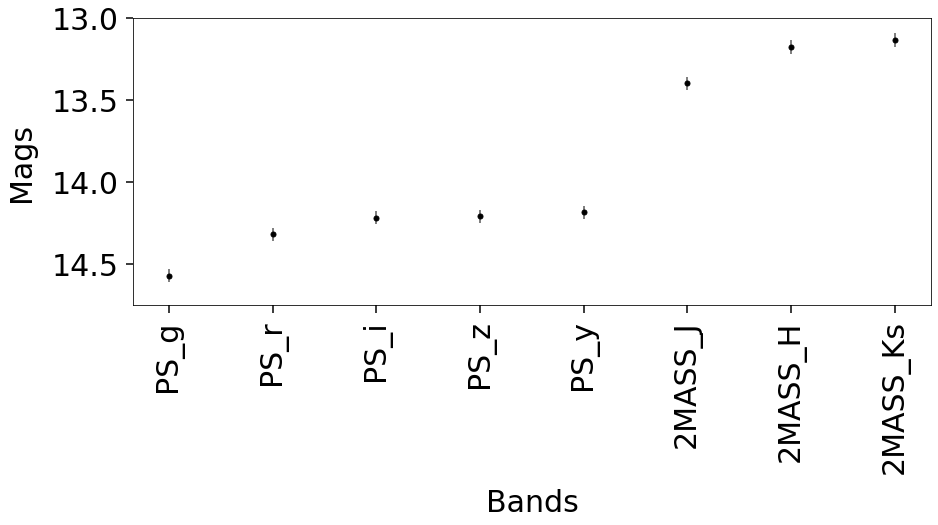

In [25]:
# generate mock data

mini, feh, eep = 1.2, -0.7, 450.
av, rv, dist = 0.5, 3.1, 2000.

mag, params, _ = sedmaker.get_sed(mini=mini, feh=feh, eep=eep, 
                                  av=av, rv=rv, dist=dist)
mag_err = np.full_like(mag, 0.02)
flux, flux_err = butils.inv_magnitude(mag, mag_err)

plt.figure(figsize=(14, 8))
plt.errorbar(np.arange(len(filt)), mag, ms=10, lw=2,
             yerr=2.*mag_err, fmt='k.', ecolor='gray')
plt.xticks(np.arange(len(filt)), filt, rotation=90)
plt.xlabel('Bands')
plt.ylim([14.75, 13])
plt.ylabel('Mags')
plt.tight_layout()

Note that the apparent "break" in the SED is because while Pan-STARRS is defined in the AB system, 2MASS is defined in the Vega system.

In [68]:
# define likelihood
def lnlike(theta):
    mini, feh, eep, av, rv, dist = theta  # parameters
    mpred, _, _ = sedmaker.get_sed(mini=mini, feh=feh, eep=eep, 
                                   av=av, rv=rv, dist=dist)  # SED
    fpred, _ = butils.inv_magnitude(mpred, np.full_like(mpred, 0.02))  # mag->flux
    
    chi2 = np.sum((flux - fpred)**2 / flux_err**2)
    const = np.sum(np.log(2. * np.pi * flux_err**2))
    
    return -0.5 * (chi2 + const)

In [96]:
# define center
mean = np.array([mini, feh, eep, av, rv, dist])
scatter = np.array([0.02, 0.05, 10, 0.05, 0.2, dist * 0.02])

# draw values
draws = np.random.normal(mean, scatter, size=(50000, 6))

# evaluate log-likelihood
lnprobs = np.array([lnlike(x) for x in draws])
weights = np.exp(lnprobs - np.nanmax(lnprobs))
weights[~np.isfinite(weights)] = 0.

We can visualize the resulting uncertainty using packages like `corner`.

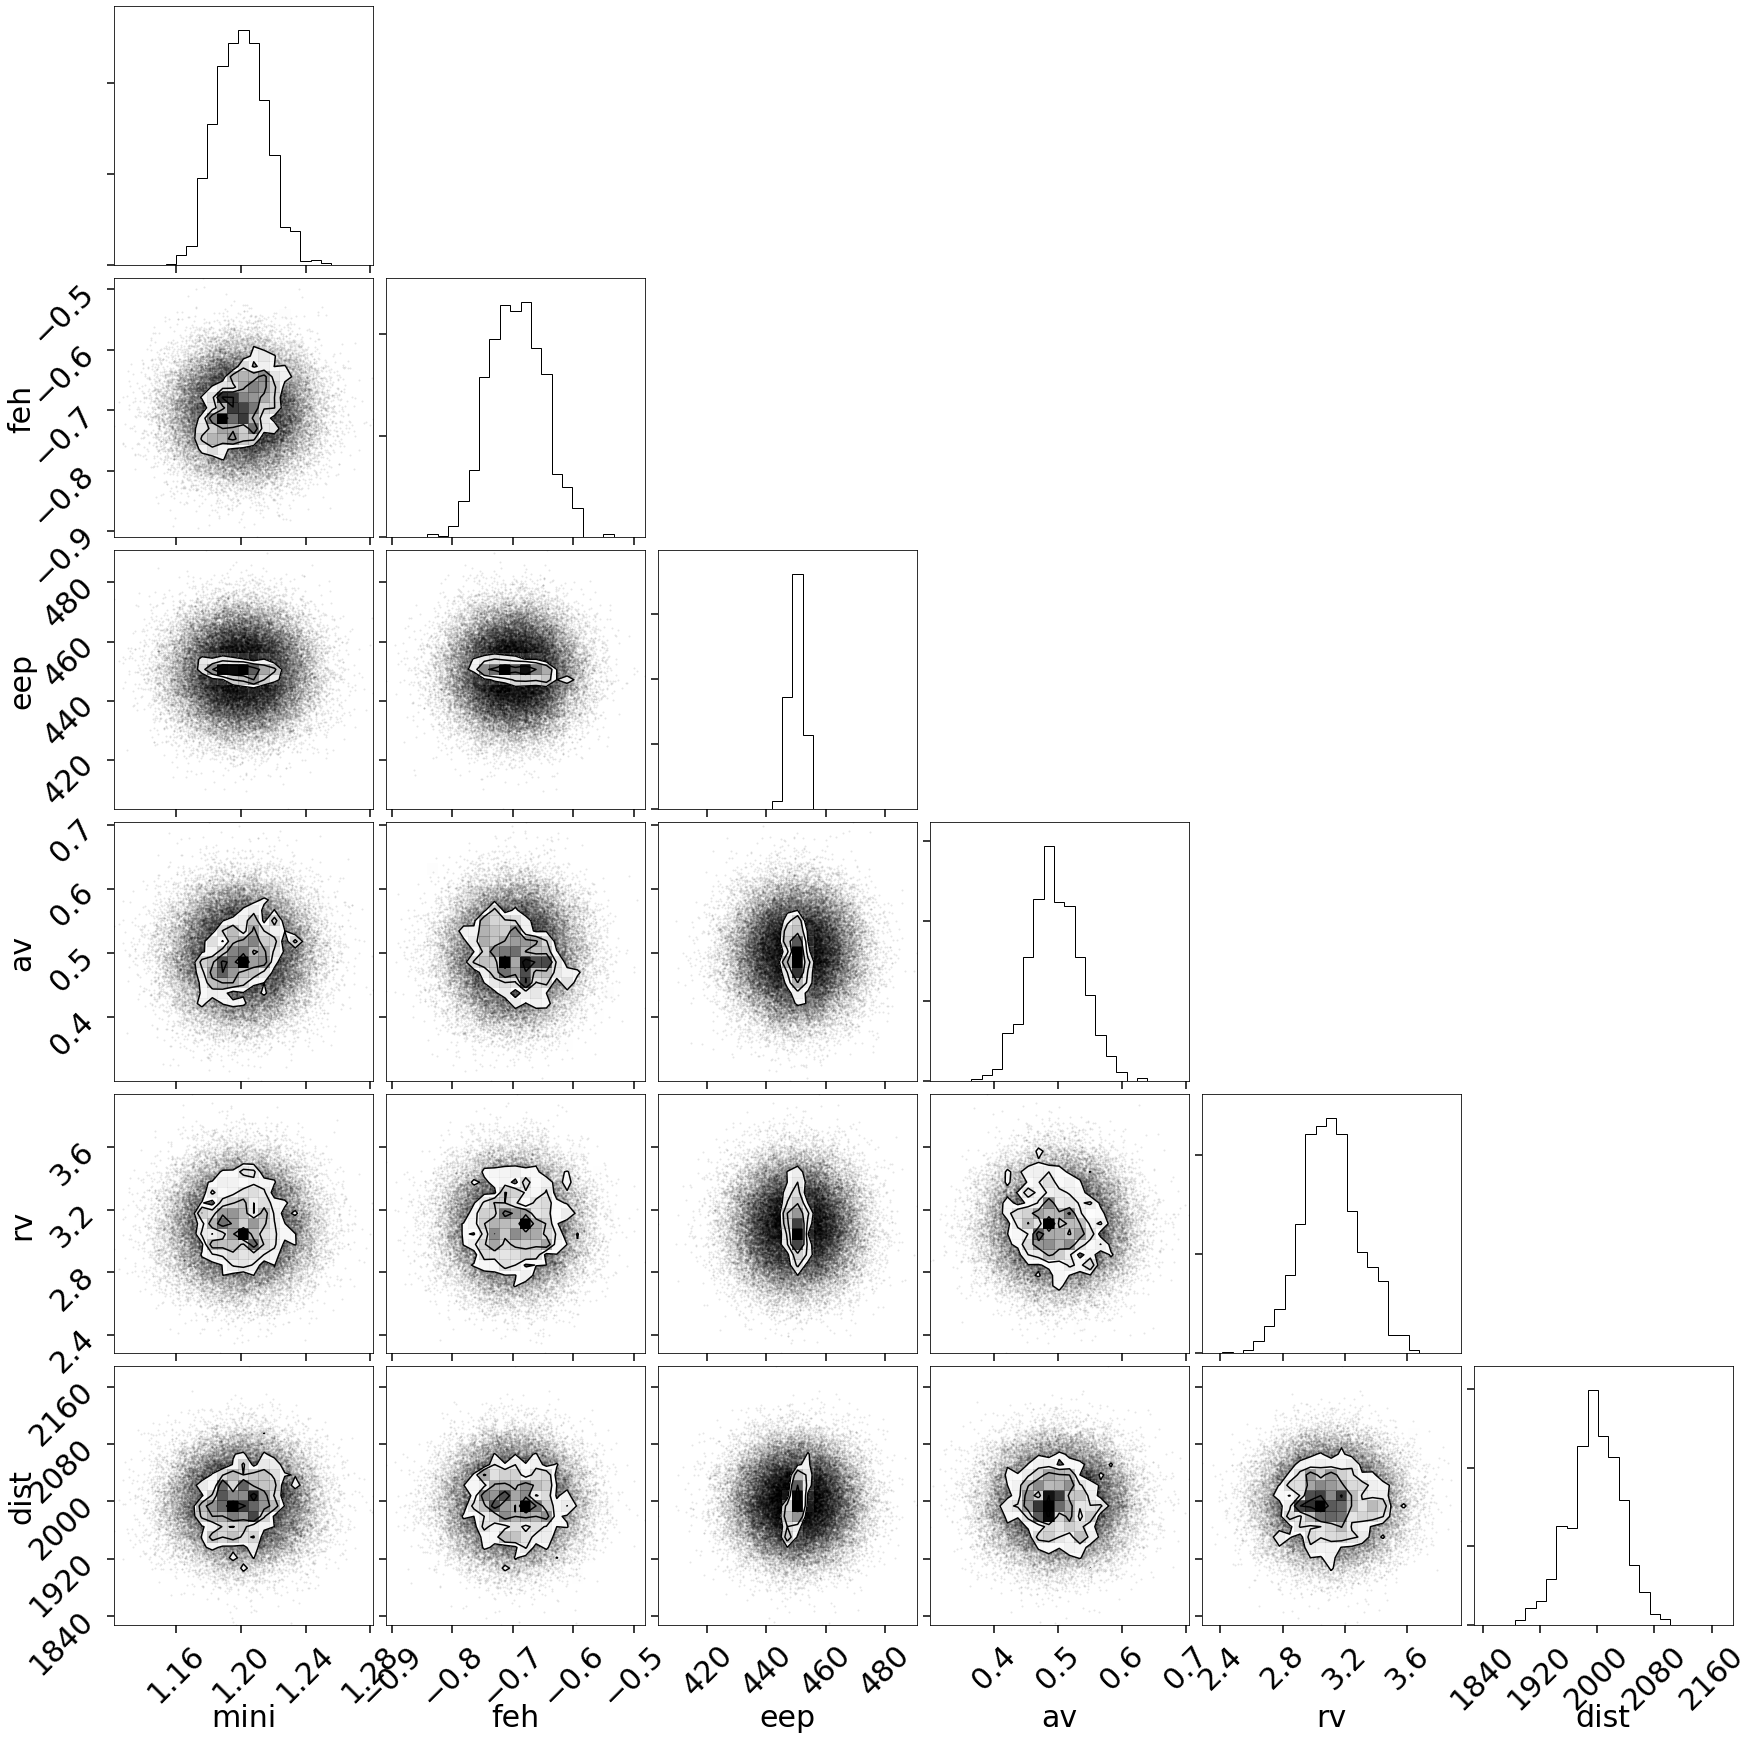

In [105]:
import corner

corner.corner(draws, weights=weights, bins=25,
              fig=plt.subplots(6, 6, figsize=(25, 25))[0],
              labels=['mini', 'feh', 'eep', 'av', 'rv', 'dist']);

# BruteForce

The core inference engine for individual sources is the `BruteForce` class in the `fitting` module. This is also what gives `brutus` it's name. Rather than try to sample from parameters, `BruteForce` instead breaks up the problem into 3 parts:

1. Finding extinction $A(V)$, differential extinciton $R(V)$, and distance $d$ for a fixed set of stellar parameters.
2. Incorporating information from other external constraints, including priors, parallax measurements, and the like.
3. Parallelizing the above problems across a **grid** of stellar models (the "brute force" part).

Exploiting various statistical and computational tricks unique to each part allows this approach to be *extremely* fast, with most sources modeled in less than a few seconds.

Let's now initialize a `BruteForce` class using the grid of models we loaded in previously.

In [106]:
from brutus.fitting import BruteForce

# initialize `BruteForce` class
BF_mist = BruteForce(models_mist, labels_mist, lmask_mist)

## Data

Unlike the example above where we were dealing with a single object, `BruteForce` is designed to model large populations of objects. As such, we will load in a test dataset taken from a sightline in Orion analyzed in Zucker & Speagle et al. (2019) to illustrate how the class works. Note that `BruteForce` expects data to be in a specific format. In particular:

- Photometry should be provided in **fluxes**, not magnitudes, and in units of **maggies** (i.e. $10^{-0.4 m}$, where $m$ is the magnitude in native units of the survey)
- Parallaxes should be provided in units of mas (i.e. native units for *Gaia*).
- Coordinates (needed to evaluate the Galactic prior) should be provided in Galactic coordinates (i.e. $\ell$ and $b$).

In [107]:
# load in data
filename = 'Orion_l204.7_b-19.2'
f = h5py.File(filename+'.h5', 'r')
fpix = f['photometry']['pixel 0-0']
mag, magerr = fpix['mag'], fpix['err']
mask = np.isfinite(magerr)  # create boolean band mask
phot, err = butils.inv_magnitude(mag, magerr)  # convert to flux (in maggies)
objid = fpix['obj_id']  # grab object id
parallax, parallax_err = fpix['parallax'] * 1e3, fpix['parallax_error'] * 1e3  # convert to mas
psel = np.isclose(parallax_err, 0.) | np.isclose(parallax, 0.) | (parallax_err > 1e6)
parallax[psel], parallax_err[psel] = np.nan, np.nan
coords = np.c_[fpix['l'], fpix['b']]

Nobjs = len(phot)
print(Nobjs)

1642


/home/joshspeagle/anaconda3/lib/python3.7/site-packages/brutus-0.8.2-py3.7.egg/brutus/utils.py:791: RuntimeWarning: overflow encountered in power
  phot = 10**(-0.4 * mag) * zeropoints


## Photometric Offsets

Mean photometric offsets between the data and the models in a particular grid are provided online. These can be easily loaded in using the `load_offsets` function and subsequently applied to the data using the appropriate argument in `BruteForce`. An example illustrating how to derive these using functions available in `brutus` is shown in a separate notebook.

In [108]:
# load offsets
off_file_mist = '../data/DATAFILES/offsets_mist_v8.txt'
print('MIST photometric offsets:')
off_mist = butils.load_offsets(off_file_mist, filters=filt)

MIST photometric offsets:


PS_g (0.0%)
PS_r (-3.0%)
PS_i (-3.0%)
PS_z (-2.0%)
PS_y (-4.0%)
2MASS_J (-2.0%)
2MASS_H (1.0%)
2MASS_Ks (-2.0%)


## Fitting the Data

There are a large number of "bells and whistles" involved in the fitting. These are described extensively in the documentation. A few options are highlighted below.

In [110]:
np.random.seed(862)

dustfile = '../data/DATAFILES/bayestar2019_v1.h5'  # 3-D dust map

# fit a set of hypothetical objects
BF_mist.fit(phot[:50],  # fluxes (in maggies)
            err[:50],  # errors (in maggies)
            mask[:50],  # band mask (True/False whether band was observed)
            objid[:50],  # additional information to be written out
            filename+'_mist',  # filename where results are stored (.h5 automatically added)
            data_coords=coords[:50],  # array of (l, b) coordinates for Galactic prior
            parallax=parallax[:50], parallax_err=parallax_err[:50],  # parallax measurements (in mas)
            phot_offsets=off_mist,  # photometric offsets applied to **data**
            dustfile=dustfile,  # 3-D dustmap prior
            Ndraws=250,  # number of samples to save to disk
            Nmc_prior=50,  # number of Monte Carlo draws used to incorporate priors
            logl_dim_prior=True,  # use chi2 distribution instead of Gaussian
            save_dar_draws=True,  # save (dist, Av, Rv) samples
            running_io=True,  # write out objects as soon as they finish
            verbose=True)  # print progress

Fitting object 50/50 [chi2/n: 3.2/9] (mean time: 1.716 s/obj, est. time remaining:      0.000 s)    


## Results

Results are stored in the output hdf5 file as a set of `Ndraws` samples taken from the posterior. This file contains a variety of data products produced by the fits, some of which are loaded below.

In [111]:
# load results
f = h5py.File(filename+'_mist'+'.h5', 'r')
idxs_mist = f['model_idx'][:]  # model indices
chi2_mist = f['obj_chi2min'][:]  # best-fit chi2
nbands_mist = f['obj_Nbands'][:]  # number of bands in fit
dists_mist = f['samps_dist'][:]  # distance samples
reds_mist = f['samps_red'][:]  # A(V) samples
dreds_mist = f['samps_dred'][:]  # R(V) samples
lnps_mist = f['samps_logp'][:]  # log-posterior of samples

# Visualizing Results

`brutus` contains a number of utilities for visualizing results in the `plotting` module. We illustrate a few below.

In [113]:
from brutus import plotting as bplot

One useful check is to examine the **posterior predictive**, which in this case just means the probabilistic SED derived from the posterior.

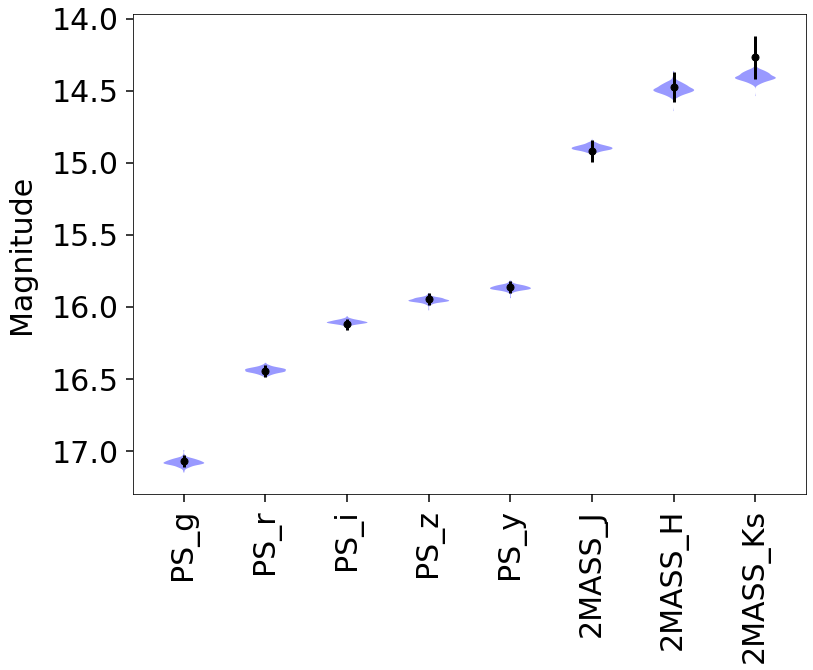

In [114]:
# pick an object
i = 3

# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_mist,  # stellar model grid
                                            idxs_mist[i],  # model indices
                                            reds_mist[i],  # A(V) draws
                                            dreds_mist[i],  # R(V) draws
                                            dists_mist[i],  # distance draws
                                            data=phot[i], data_err=err[i],  # data
                                            data_mask=mask[i],  # band mask
                                            offset=off_mist,  # photometric offsets
                                            psig=2.,  # plot 2-sigma errors
                                            labels=filt,  # filters 
                                            vcolor='blue',  # "violin plot" colors for the posteriors
                                            pcolor='black')  # photometry colors for the data

We can also generate a corner plot similar to the one originally shown, although by default this include derived stellar parameters (e.g., effective temperatures) as well.

Best-fit chi2 (MIST): 2.898432


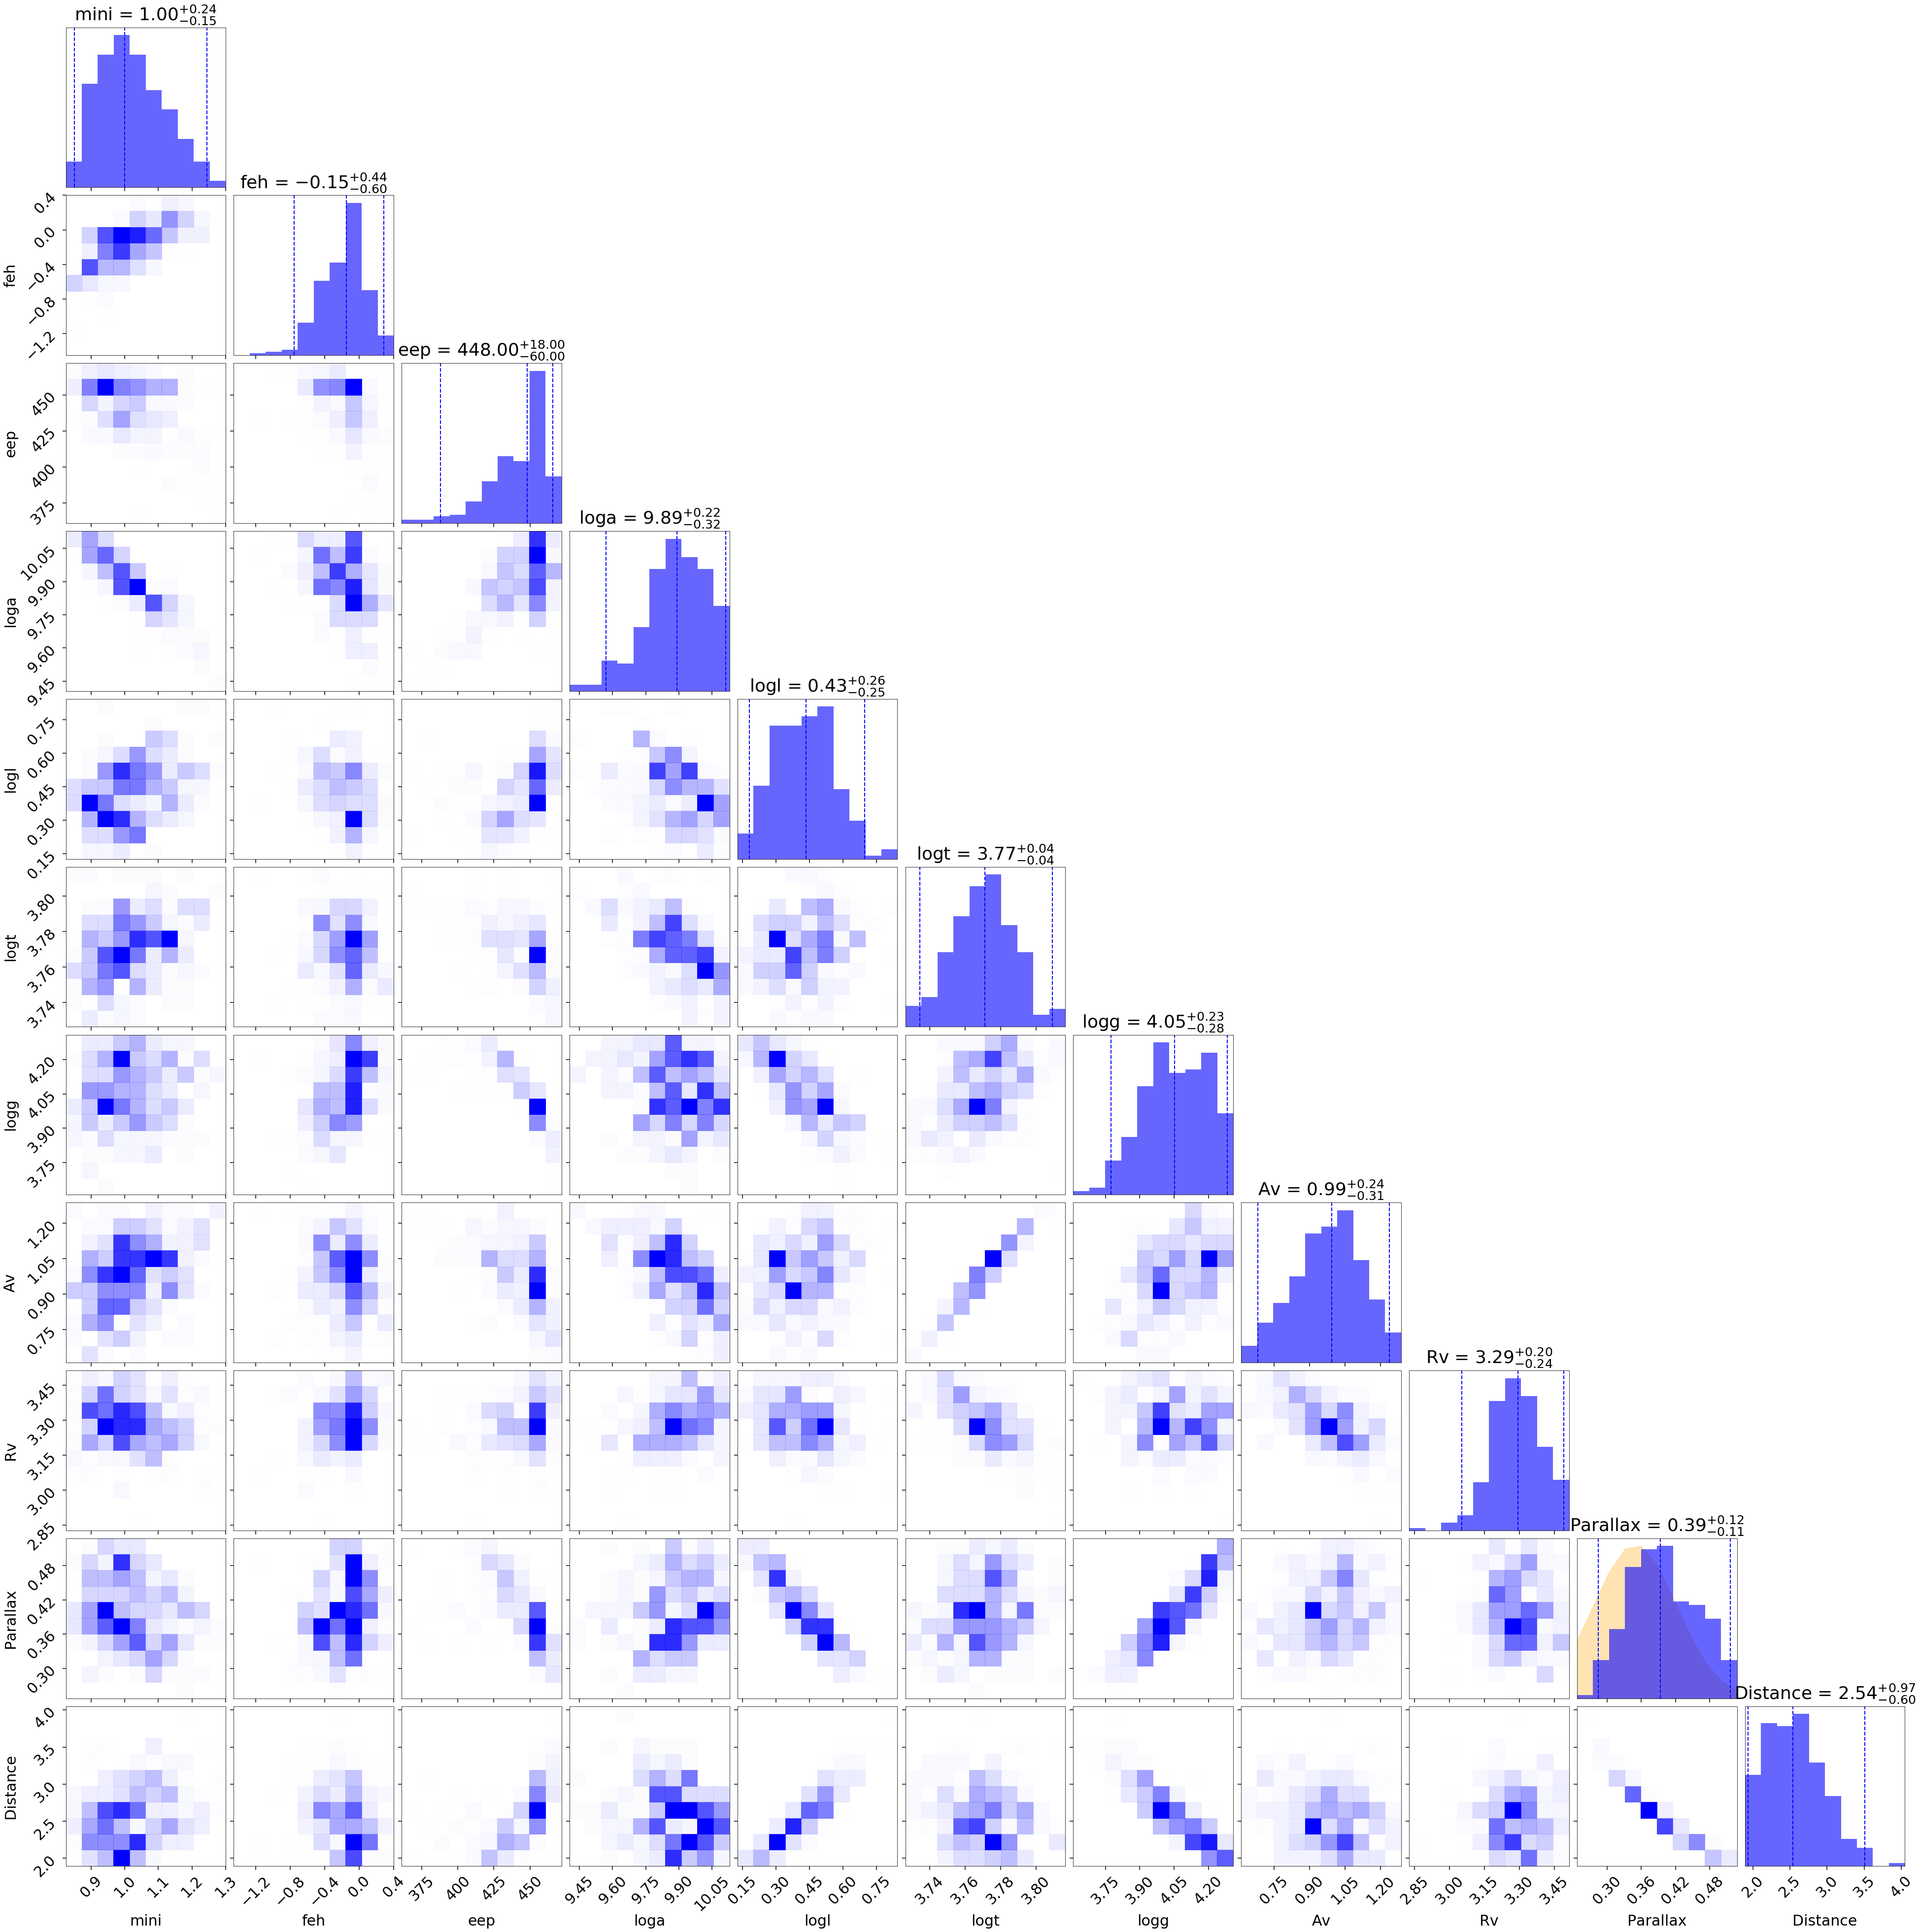

In [115]:
# plot corner

print('Best-fit chi2 (MIST):', chi2_mist[i])
fig, axes = bplot.cornerplot(idxs_mist[i], 
                             (dists_mist[i], reds_mist[i], dreds_mist[i]),
                             labels_mist,  # model labels
                             parallax=parallax[i], parallax_err=parallax_err[i],  # overplot if included
                             show_titles=True, color='blue', pcolor='orange',
                             fig=plt.subplots(11, 11, figsize=(55, 55)))  #  custom figure

It can also be helpful to visualize the marginal 2-D distance-extinction posterior distribution in more detail.

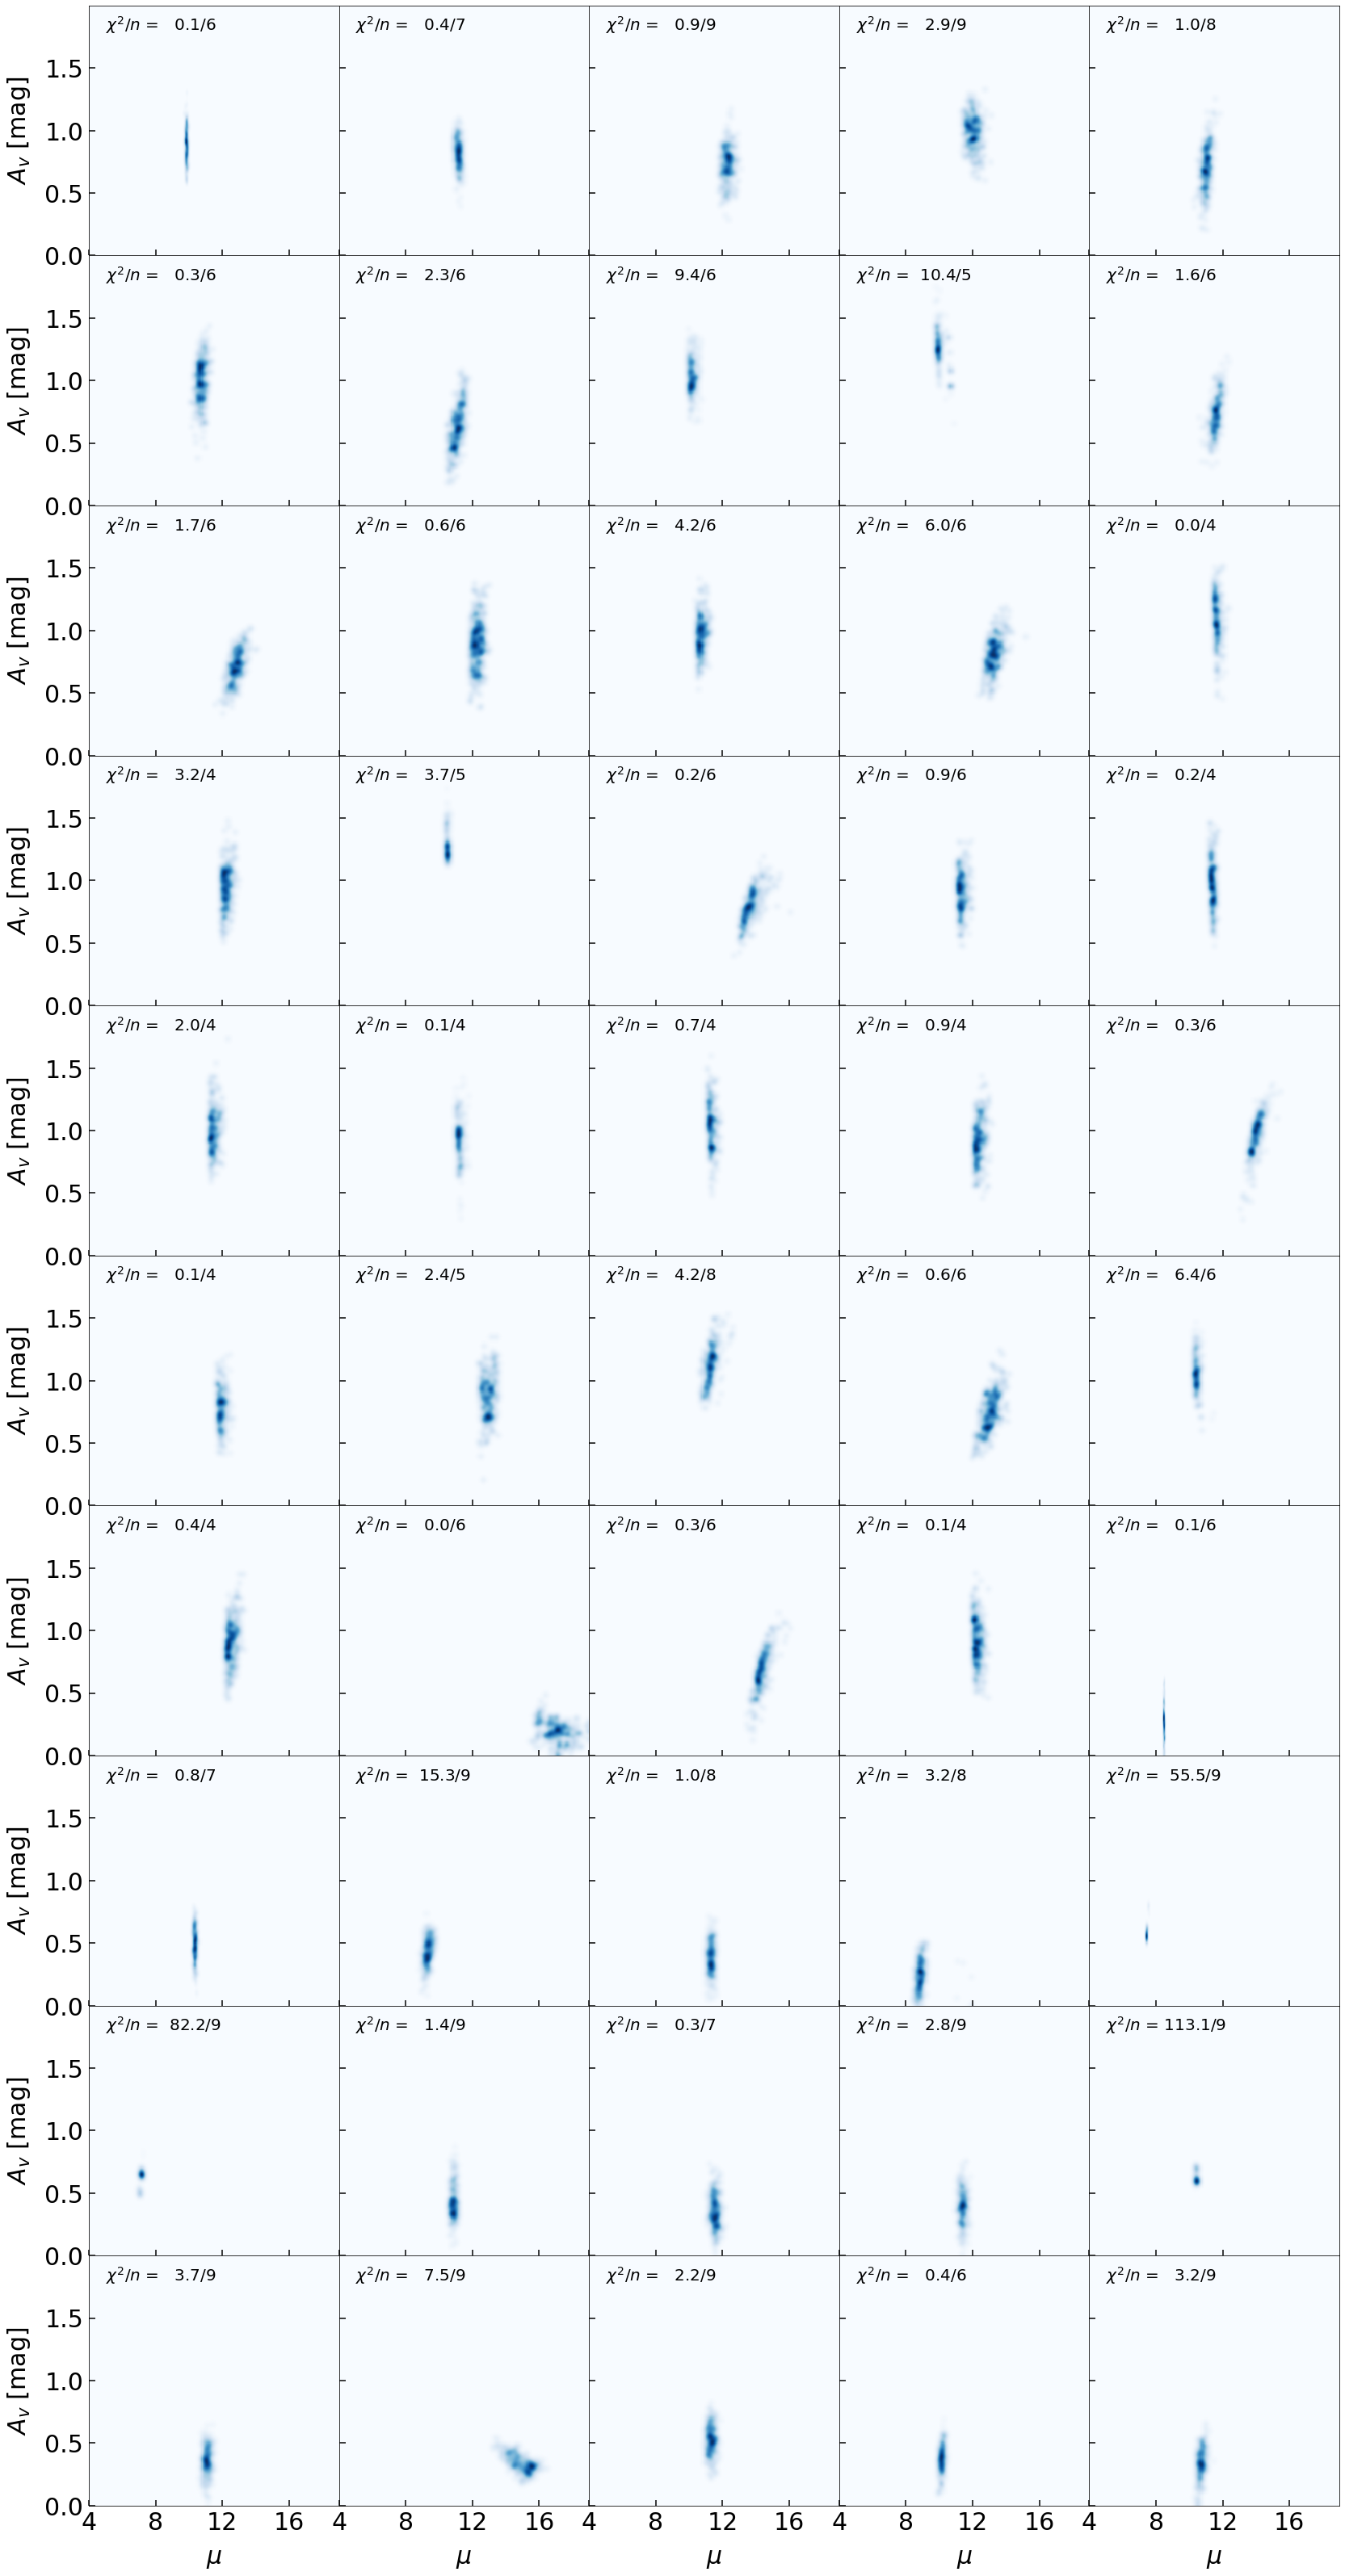

In [142]:
xdim, ydim = 25, 50

# distance-reddening 2-D posteriors
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_mist[i], reds_mist[i], dreds_mist[i]), 
                      parallax=parallax[i],  # limits smoothing
                      parallax_err=parallax_err[i],  # if parallax SNR is high
                      avlim=(0., 2.),
                      cmap='Blues')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])
    plt.text(5., 1.8, r'$\chi^2/n$ ={:6.1f}/{:d}'
             .format(chi2_mist[i], nbands_mist[i]),
             fontsize=20)

# Bayestar Models

As mentioned in a previous notebook, `brutus` also contains an empirical stellar model grid generated from the "Bayestar" models. Since `BruteForce` can run over an arbitrary model grid, it is straightforward to simply swap this in and run the same objects to see if there are any differences. We demonstrate this below.

In [133]:
# import Bayestar model grid
gridfile_bs = '../data/DATAFILES/grid_bayestar_v5.h5'
(models_bs, labels_bs, lmask_bs) = butils.load_models(gridfile_bs, filters=filt)

Reading filter 2MASS_Ks           


In [134]:
# load offsets
off_file_bs = '../data/DATAFILES/offsets_bs_v5.txt'
print('Bayestar photometric offsets:')
off_bs = butils.load_offsets(off_file_bs, filters=filt)

Bayestar photometric offsets:


PS_g (-0.5%)
PS_r (-0.4%)
PS_i (-0.7%)
PS_z (-0.4%)
PS_y (0.0%)
2MASS_J (-0.3%)
2MASS_H (0.9%)
2MASS_Ks (0.8%)


In [135]:
BF_bs = BruteForce(models_bs, labels_bs, lmask_bs)

In [136]:
np.random.seed(6192)

# fit a set of hypothetical objects
BF_bs.fit(phot[:50], err[:50], mask[:50], objid[:50], filename+'_bs',
          data_coords=coords[:50],
          parallax=parallax[:50], parallax_err=parallax_err[:50],
          phot_offsets=off_bs, dustfile=dustfile)

Fitting object 50/50 [chi2/n: 1.6/9] (mean time: 0.234 s/obj, est. time remaining:      0.000 s)    


Since the Bayestar grid is a lot smaller than the MIST one, the runtime is also much faster.

In [137]:
# load results
f = h5py.File(filename+'_bs'+'.h5', 'r')
idxs_bs = f['model_idx'][:]
chi2_bs = f['obj_chi2min'][:]
nbands_bs = f['obj_Nbands'][:]
dists_bs = f['samps_dist'][:]
reds_bs = f['samps_red'][:]
dreds_bs = f['samps_dred'][:]
lnps_bs = f['samps_logp'][:]

Best-fit chi2 (Bayestar): 3.6857517


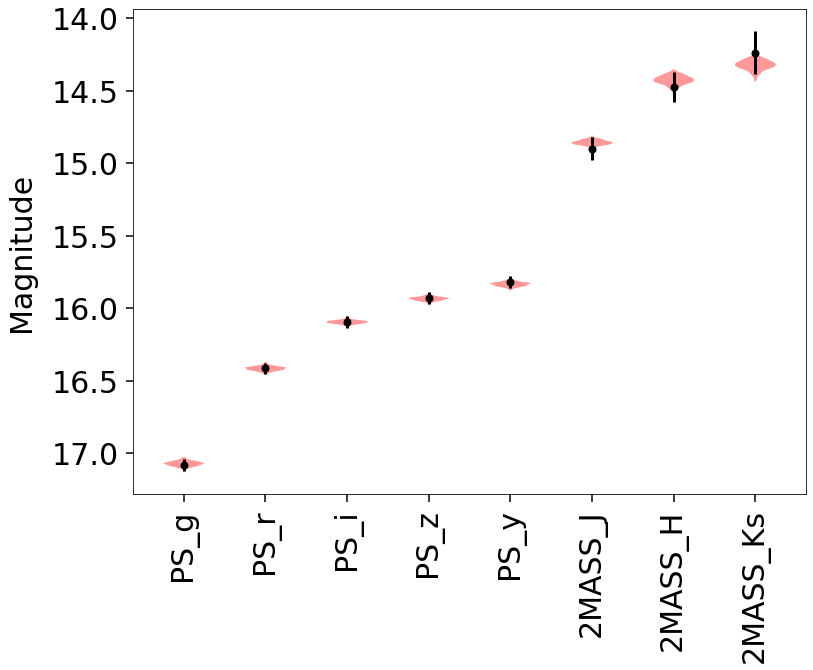

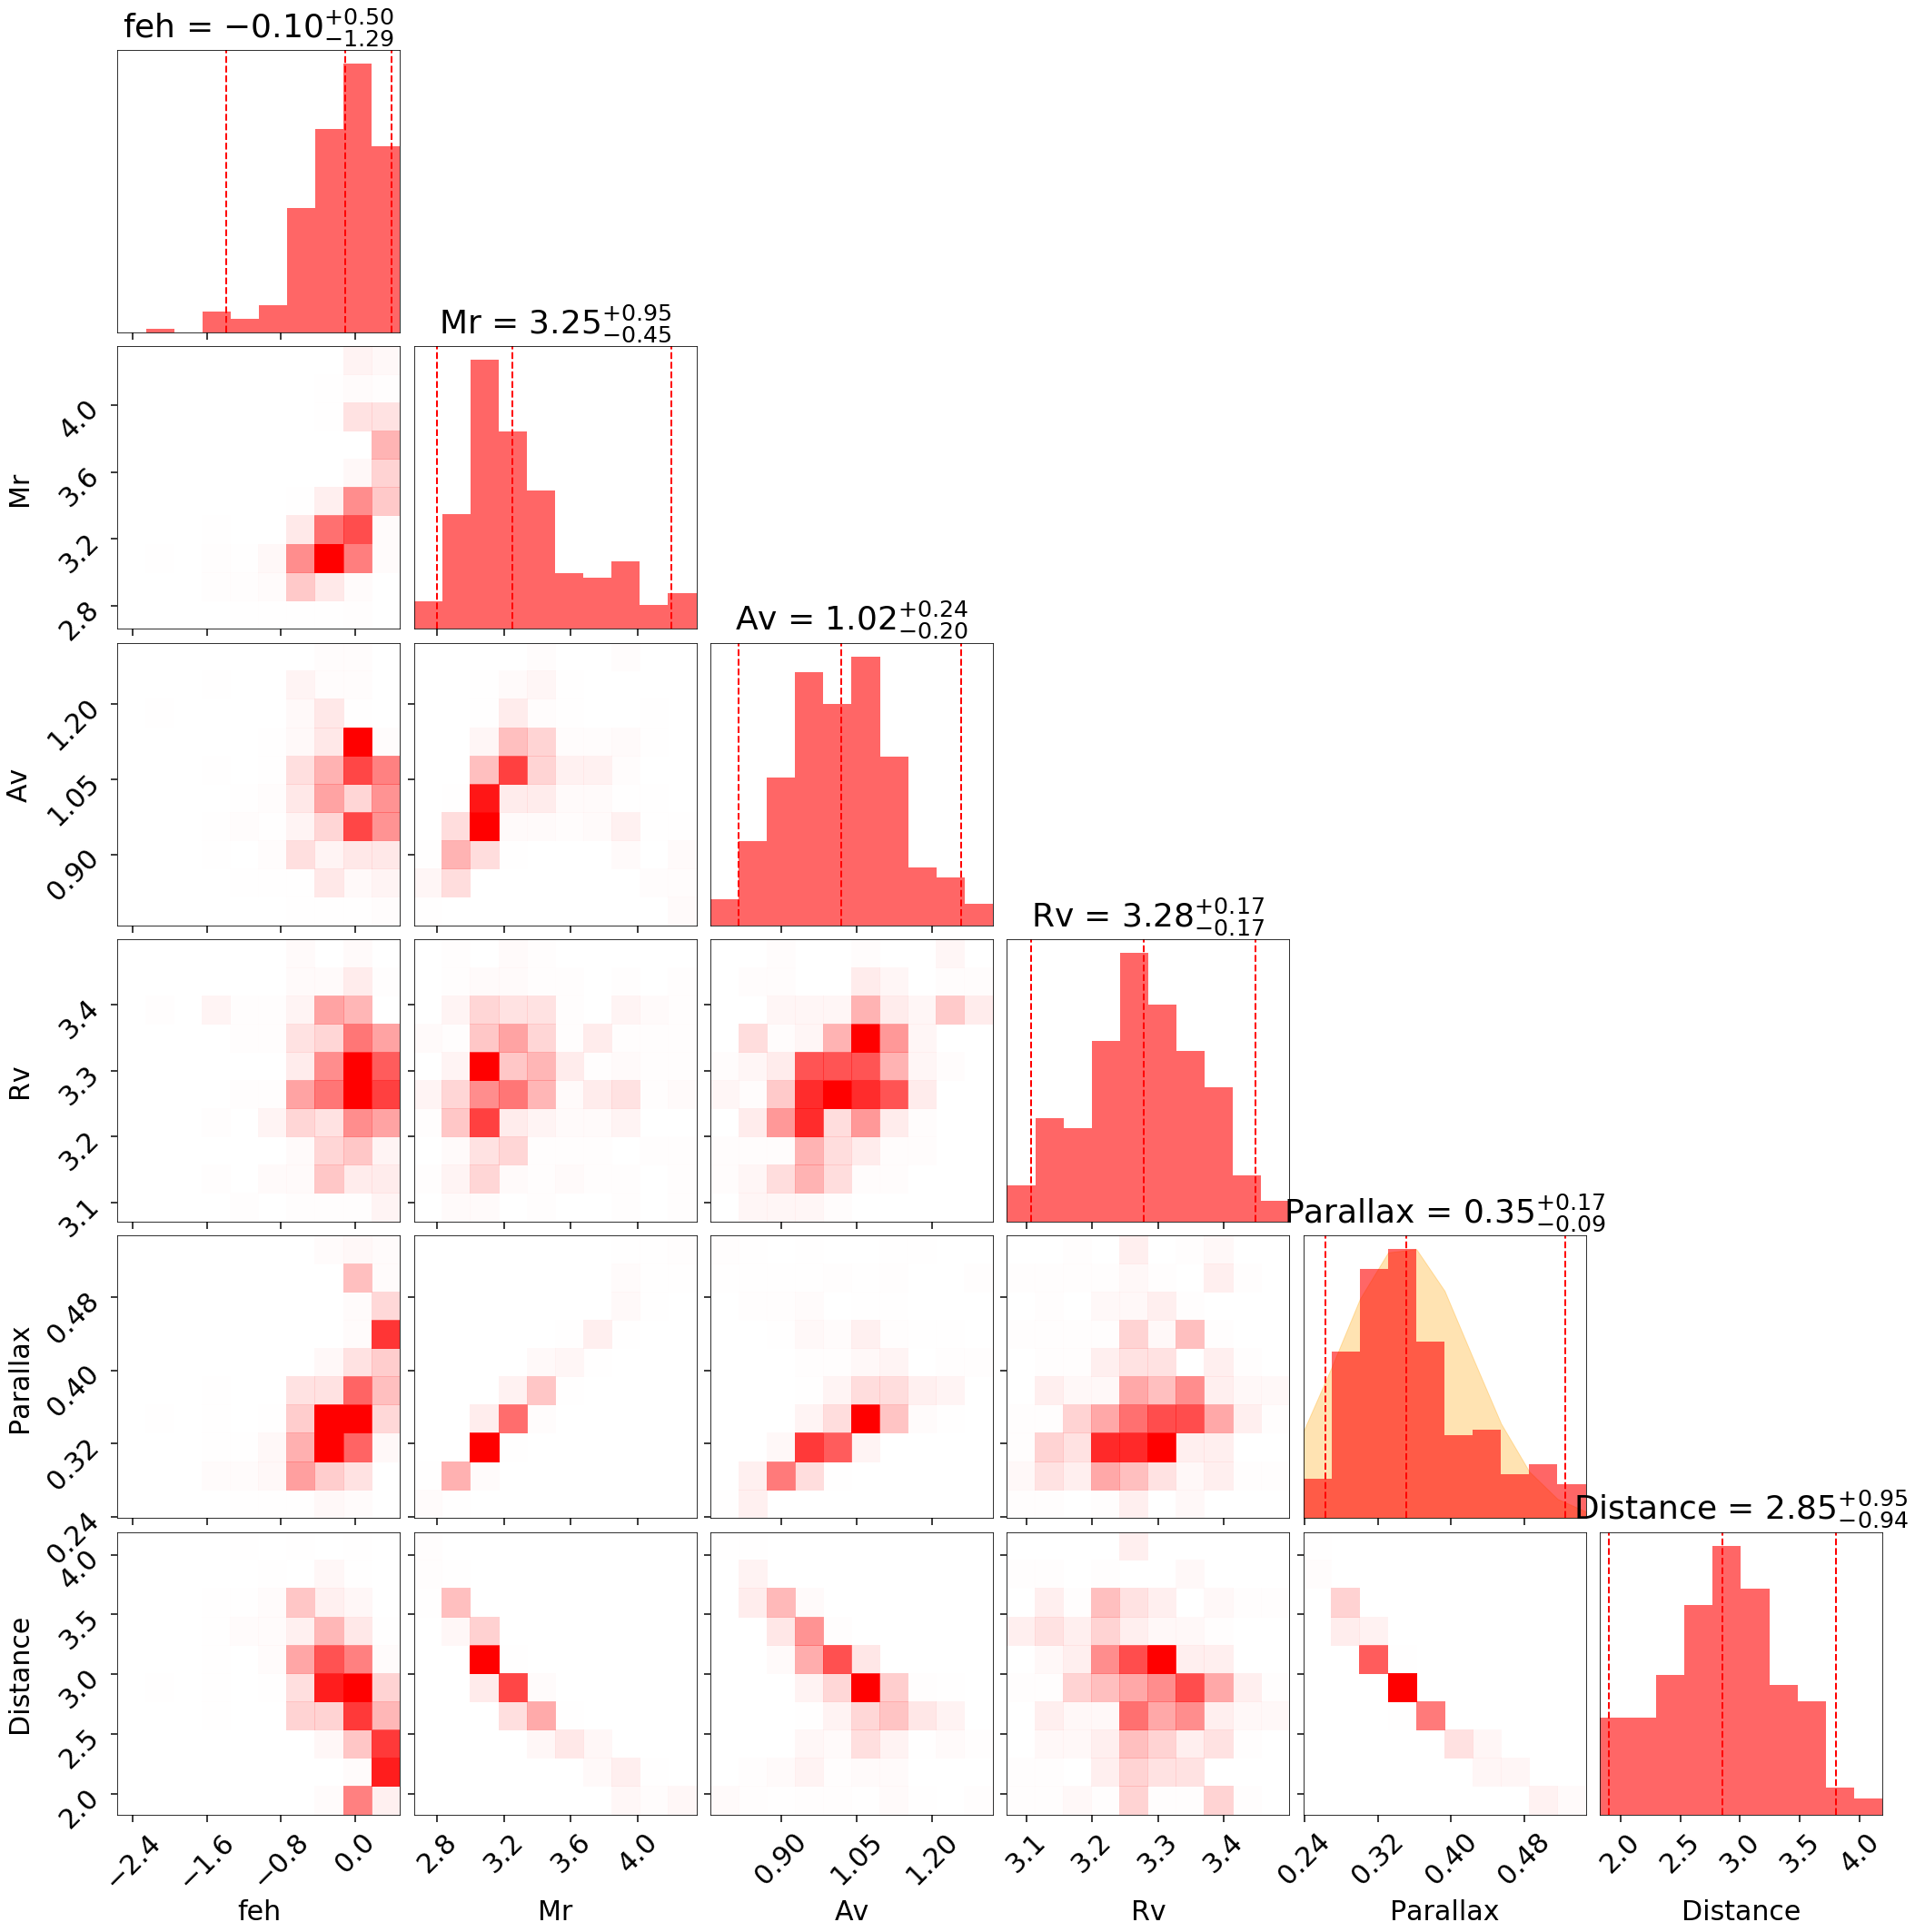

In [140]:
# pick object
i = 3

# plot SED (posterior predictive)
fig, ax, parts = bplot.posterior_predictive(models_bs, idxs_bs[i],
                                            reds_bs[i], dreds_bs[i], dists_bs[i],
                                            data=phot[i], data_err=err[i],
                                            data_mask=mask[i],
                                            offset=off_bs,
                                            labels=filt, psig=2.,
                                            vcolor='red', pcolor='black')

# plot corner
print('Best-fit chi2 (Bayestar):', chi2_bs[i])
fig, axes = bplot.cornerplot(idxs_bs[i], 
                             (dists_bs[i], reds_bs[i], dreds_bs[i]),
                             labels_bs,
                             parallax=parallax[i], parallax_err=parallax_err[i],
                             show_titles=True, color='red', pcolor='orange',
                             fig=plt.subplots(6, 6, figsize=(30, 30)))

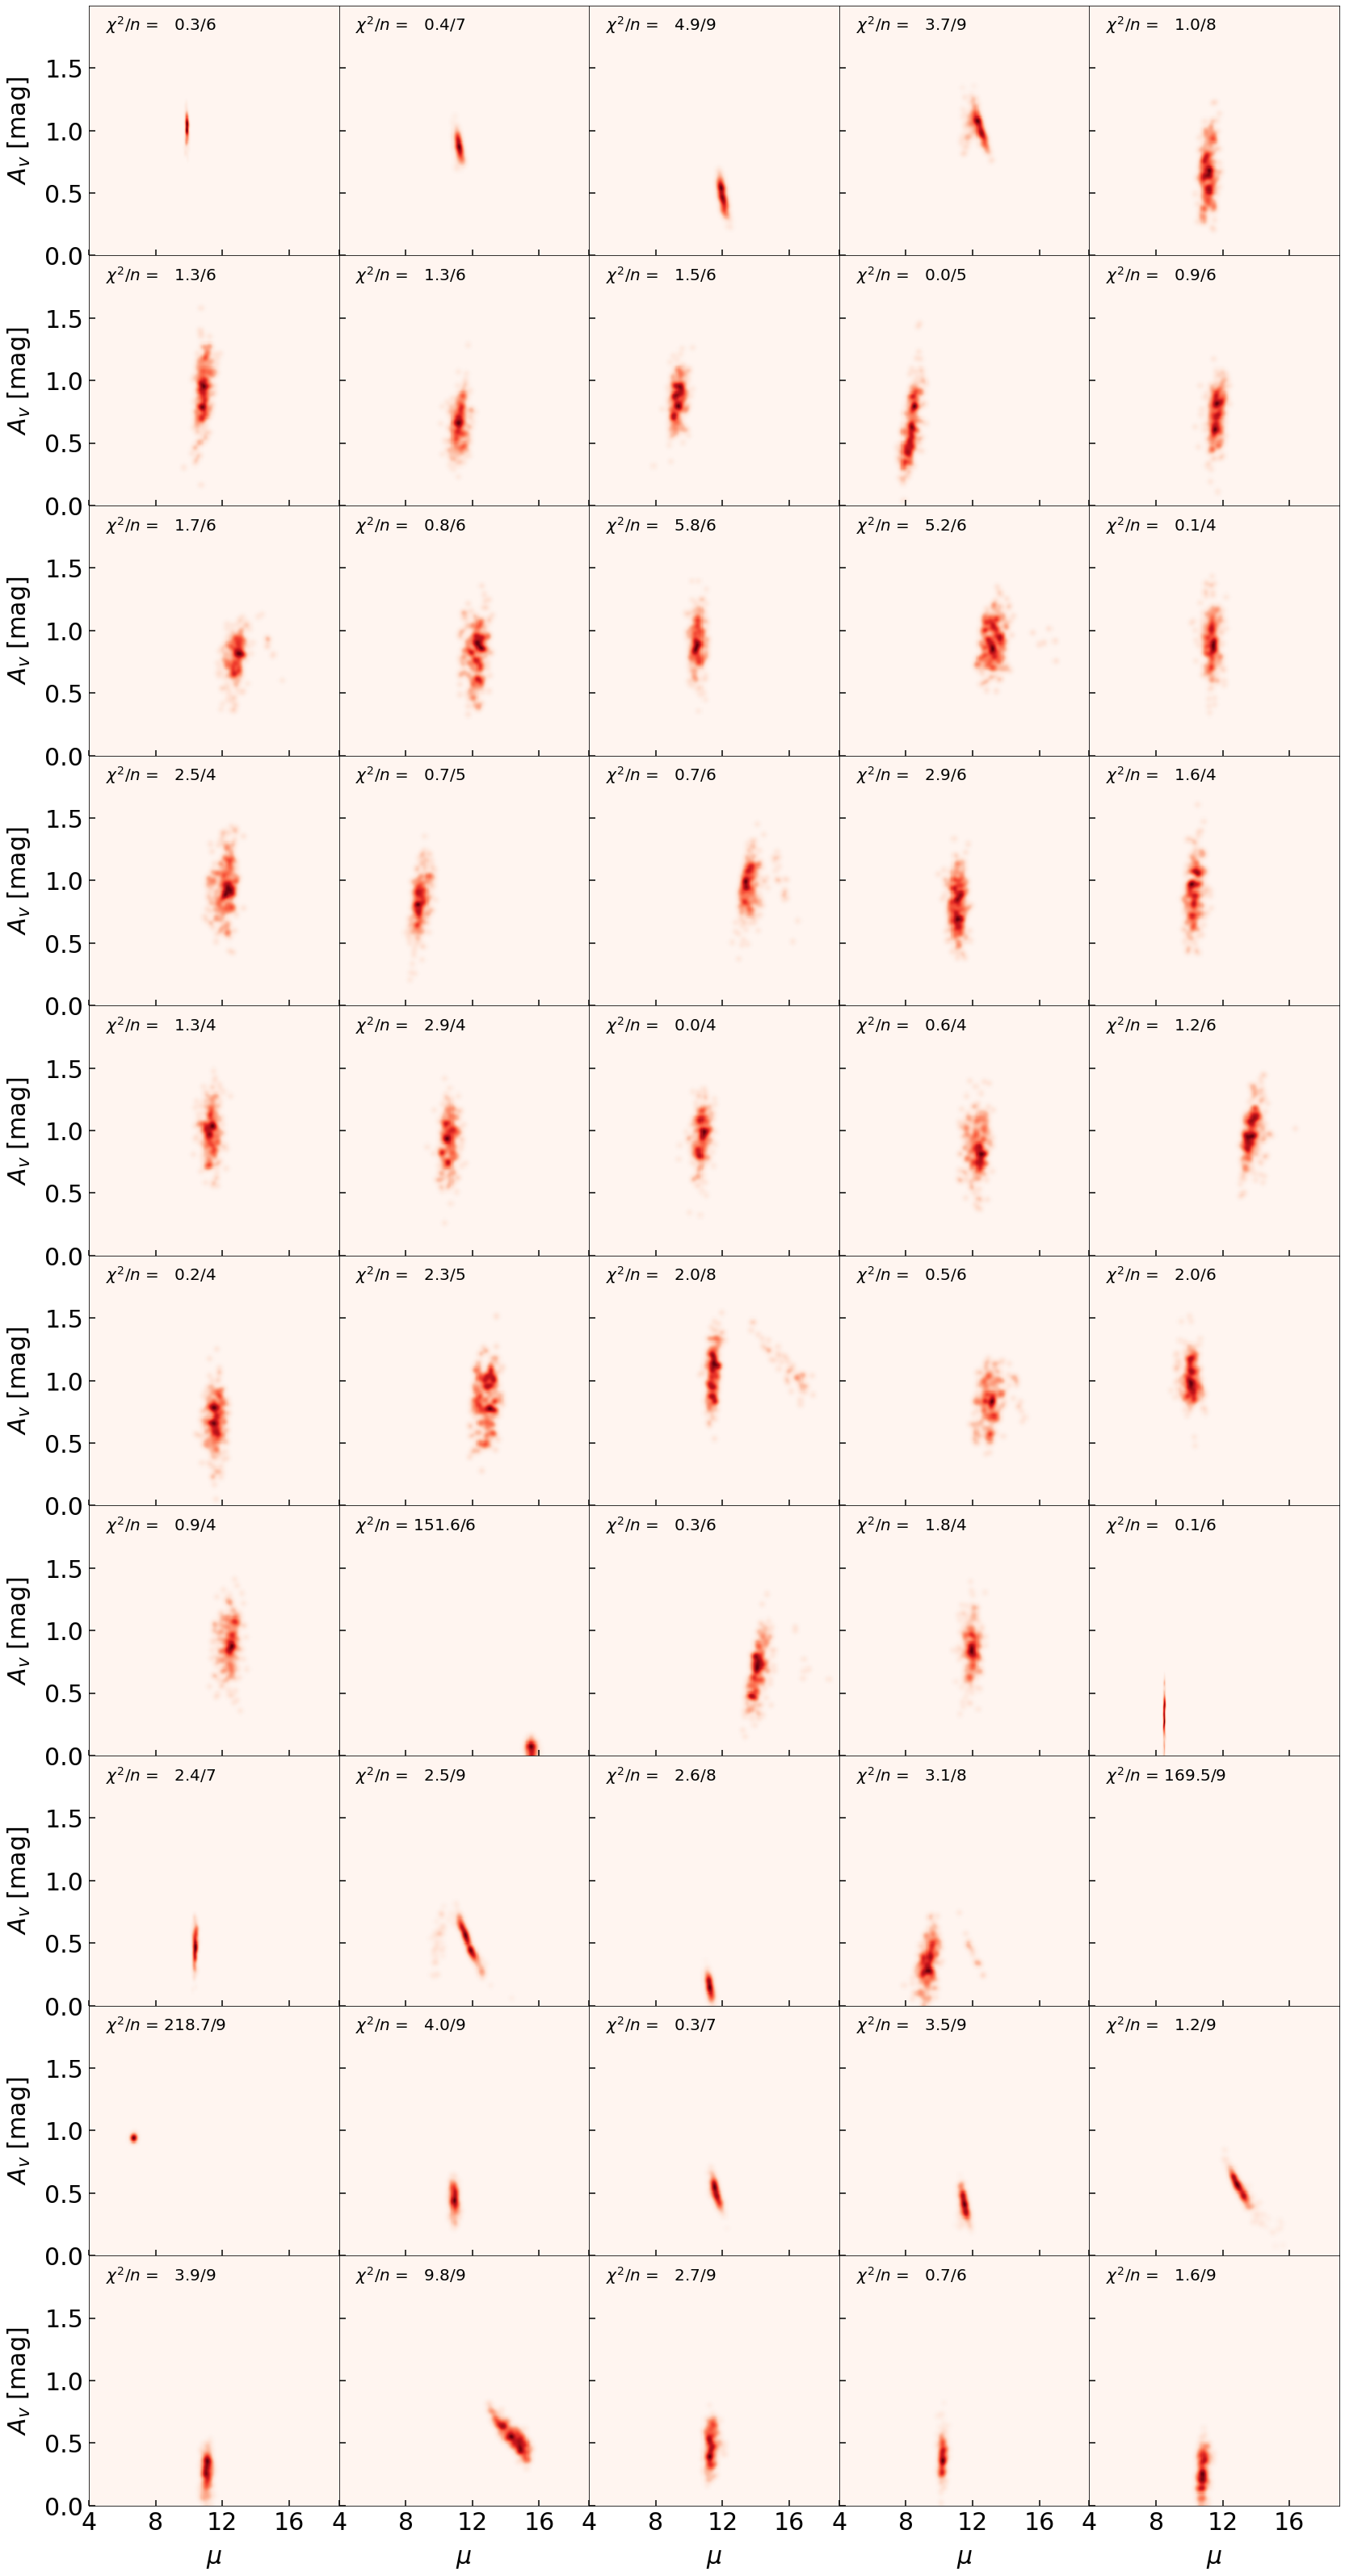

In [143]:
xdim, ydim = 25, 50

# distance-reddening 2-D posteriors
fig = plt.figure(figsize=(xdim, ydim))
fig.subplots_adjust(bottom=0.12, top=0.98,
                    left=0.12, right=0.98,
                    wspace=0.00, hspace=0.00)
for i in range(xdim//5 * ydim//5):
    plt.subplot(ydim//5, xdim//5, i+1)
    bplot.dist_vs_red((dists_bs[i], reds_bs[i], dreds_bs[i]), 
                      parallax=parallax[i],
                      parallax_err=parallax_err[i],
                      avlim=(0., 2.),
                      cmap='Reds')
    plt.tick_params(direction='in')
    if i % 5 == 0 and i >= xdim//5 * ydim//5 - 5:
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5))
    elif i % 5 == 0:
        plt.xlabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5))
    elif i >= xdim//5 * ydim//5 - 5:
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.))
        plt.yticks(np.arange(0., 2., 0.5), [])
    else:
        plt.xlabel('')
        plt.ylabel('')
        plt.xticks(np.arange(4., 19., 4.), [])
        plt.yticks(np.arange(0., 2., 0.5), [])
    plt.text(5., 1.8, r'$\chi^2/n$ ={:6.1f}/{:d}'
             .format(chi2_bs[i], nbands_bs[i]),
             fontsize=20)

# Utilities

`brutus` contains a suite of utilities to help analyze some of the outputs within the `utils` module. A few examples are highlighted below.

## Covariance Structure

As part of the fitting process, `BruteForce` saves estimated covariances between $A(V)$, $R(V)$, and $s$ ("scale factor", which is defined as $s=\varpi^2$, where $\varpi$ is the parallax) for various models. These can be read back in and analyzed for users interested in seeing the expected covariance for a fixed intrinsic SED using the `draw_sar` function.

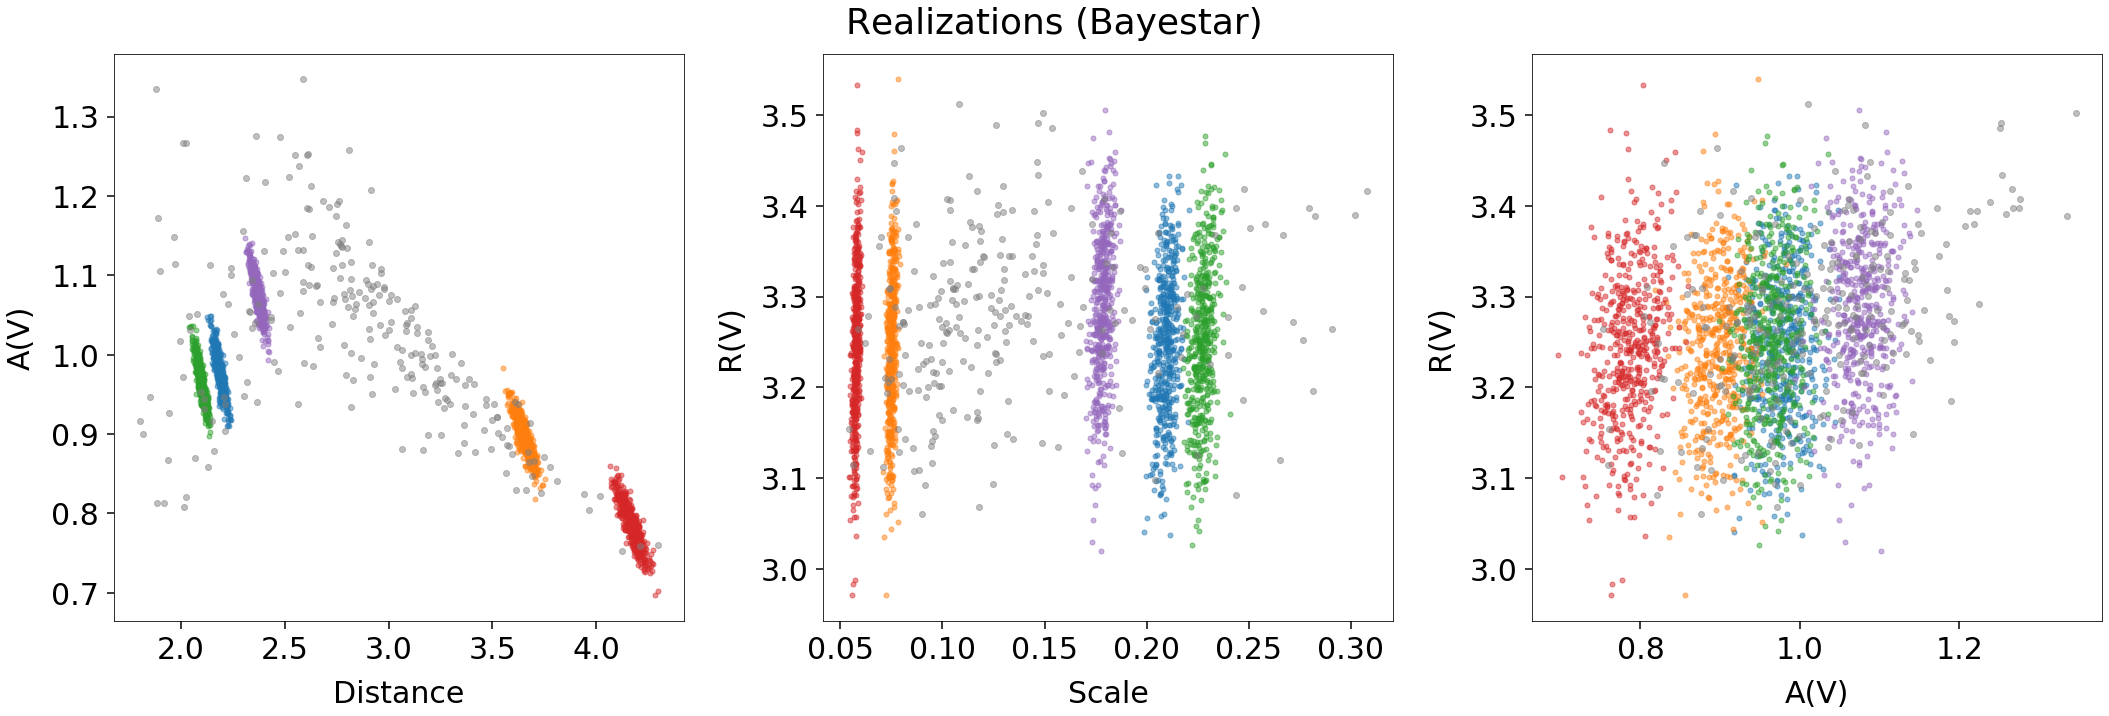

In [156]:
# load Bayestar results
f = h5py.File(filename+'_bs'+'.h5', 'r')
scales = f['ml_scale'][:]  # maximum-likelihood (ML) scale-factor
avs = f['ml_av'][:]  # ML A(V)
rvs = f['ml_rv'][:]  # ML R(V)
covs_sar = f['ml_cov_sar'][:]  # ML covariances

# pick object
i = 3

# draw reddening realizations (ignores non-Gaussian priors)
scales_r, avs_r, rvs_r = butils.draw_sar(scales[i], avs[i], rvs[i], 
                                         covs_sar[i], ndraws=500)
dists_r = 1. / np.sqrt(scales_r)  # convert from scalefactor -> distance

# plot a few results
plt.figure(figsize=(30, 10))

# av vs distance
plt.subplot(1, 3, 1)
for j in range(5):
    plt.plot(dists_r[j], avs_r[j], 'o', 
             ms=5, alpha=0.5)  # individual models
plt.plot(dists_bs[i], reds_bs[i], 'o', 
         color='gray', alpha=0.5)  # posterior samples
plt.xlabel('Distance')
plt.ylabel('A(V)')

# rv vs scale
plt.subplot(1, 3, 2)
for j in range(5):
    plt.plot(scales_r[j], rvs_r[j], 'o',
             ms=5, alpha=0.5)
plt.plot(1./dists_bs[i]**2, dreds_bs[i], 'o',
         color='gray', alpha=0.5)
plt.xlabel('Scale')
plt.ylabel('R(V)')

# av vs rv
plt.subplot(1, 3, 3)
for j in range(5):
    plt.plot(avs_r[j], rvs_r[j], 'o', 
             ms=5, alpha=0.5)
plt.plot(reds_bs[i], dreds_bs[i], 'o',
         color='gray', alpha=0.5)
plt.xlabel('A(V)')
plt.ylabel('R(V)')
plt.suptitle('Realizations (Bayestar)', y=1.02)
plt.tight_layout()

## SEDs

It is similarly straightforward to directly generate realization of the underlying SEDs using the `get_seds` function.

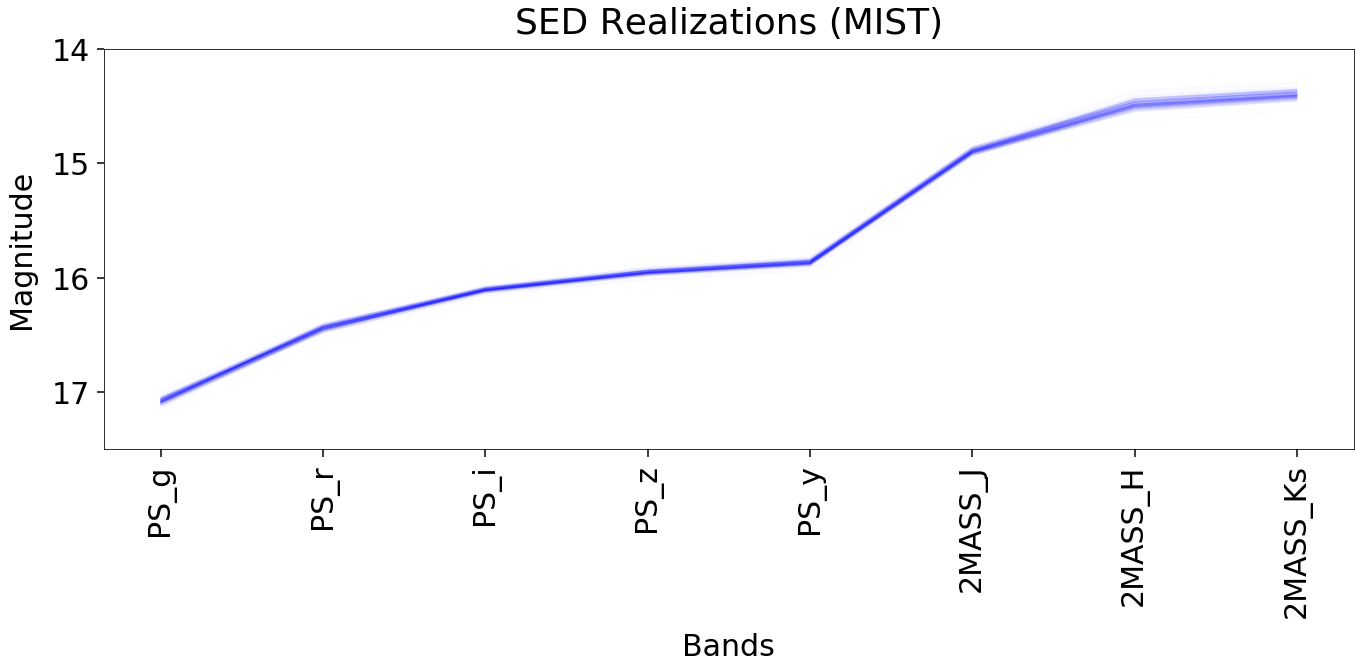

In [165]:
# pick object
i = 3

# generate SEDs
mags = butils.get_seds(models_mist[idxs_mist[i]], 
                       av=reds_mist[i], rv=dreds_mist[i])
mags += 5. * np.log10(dists_mist[i])[:, None]  # distance correction

# plot SEDs
plt.figure(figsize=(20, 10))
for j, m in enumerate(mags):
    plt.plot(m, color='blue', alpha=0.02, lw=1)
plt.xticks(np.arange(len(filt)), filt, rotation=90)
plt.xlabel('Bands')
plt.ylabel('Magnitude')
plt.ylim([17.5, 14])
plt.title('SED Realizations (MIST)')
plt.tight_layout()